## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 1000                                       # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = CURRENT_YEAR + 10_000                  # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "Anchors" notebook
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 23.1,
 5: 24.6,
 10: 25.3,
 20: 26.2,
 30: 27.0,
 40: 27.9,
 50: 29.3,
 60: 31.1,
 70: 33.1,
 80: 35.5,
 90: 38.9,
 95: 41.70499999999993,
 99: 47.5}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.7,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.6}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.39, sd=0.42)
   - 0.1 weight on <Distribution> lognorm(mean=2.25, sd=0.7)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.04, sd=0.63)
   - 0.1 weight on <Distribution> lognorm(mean=2.25, sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.04, sd=0.63)
   - 0.1 weight on <Distribution> lognorm(mean=1.7, sd=0.37)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.85 weight on <Distribution> lognorm(mean=1.7, sd=0.37)


In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(1.5, 3.5),     # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1, 4.5, lclip=0.9),
             '2025_spend_doubling_time': sq.norm(0.94, 1.02, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1054852.37it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00032,
 50: 0.00041,
 60: 0.00053,
 70: 0.00071,
 80: 0.00107,
 90: 0.00226,
 95: 0.0043,
 99: 0.00997}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
sq.get_log_percentiles(gdp_samples)

{1: '5.8e+09',
 5: '5.8e+09',
 10: '5.8e+09',
 20: '5.8e+09',
 30: '5.8e+09',
 40: '7.4e+09',
 50: '9.4e+09',
 60: '1.2e+10',
 70: '1.6e+10',
 80: '2.5e+10',
 90: '5.2e+10',
 95: '9.9e+10',
 99: '2.3e+11'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~346 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~315 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.522191% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.8 max log FLOP (628 septillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.6 to buy TAI (398 million) vs. willingness to pay log $ 8.5 (315 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 26.8 log FLOP (638 septillion) - log $ 8.4 to buy TAI (236 million) vs. willingness to pay log $ 8.8 (643 million) - 18.4 log FLO

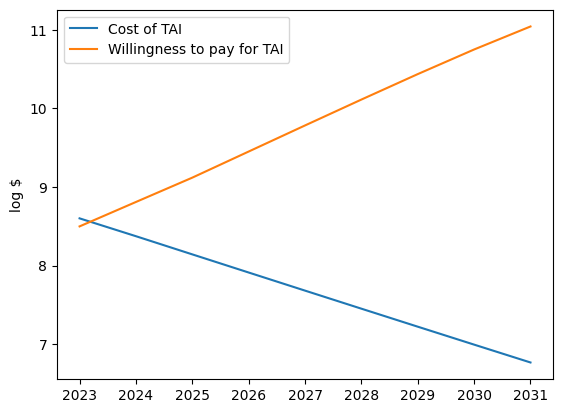

-
-
## SAMPLE RUN 2 ##
It takes 27.4 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~69 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~893 million). This doubles every 3.1 years to a max of 0.036197% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.9 (806 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 8.9 to buy TAI (766 million) vs. willingness to pay log $ 9.0 (986 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.3)
-- al

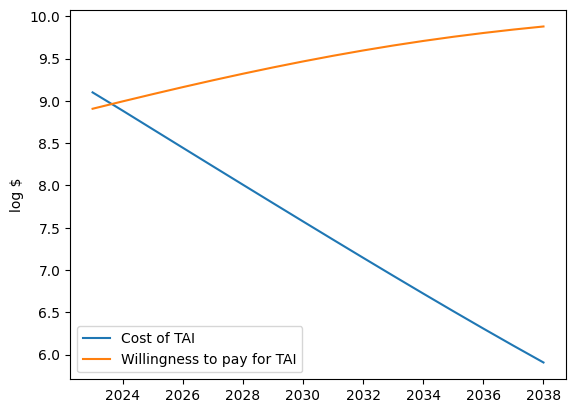

-
-
## SAMPLE RUN 3 ##
It takes 35.8 log FLOP (~631 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~54 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~249 million). This doubles every 4.6 years to a max of 0.116403% of GDP. GDP grows at a rate of 1.034x per year.
---
Year: 2023 - 26.7 max log FLOP (492 septillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.5 to buy TAI (316 quadrillion) vs. willingness to pay log $ 8.4 (247 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (790 septillion) available - TAI takes 35.6 log FLOP (398 decillion) - log $ 17.2 to buy TAI (144 quadrillion) vs. willingness to pay log $ 8.5 (286 million) - 18.4 log FLOP per $ (3 quintillion) (Effective

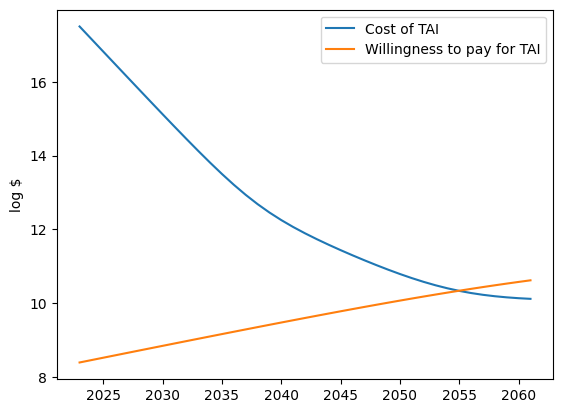

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.37it/s]


Shuffling data...
Waiting for other cores...


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.25it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2033',
 '10%: 2033',
 '15%: 2035',
 '20%: 2036',
 '25%: 2037',
 '35%: 2041',
 '50%: 2045',
 '60%: 2049',
 '75%: 2064',
 '80%: 2072',
 '90%: 2225',
 '95%: 2536']
(Mean: 2118)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 10 years from now',
 '10%: 10 years from now',
 '15%: 12 years from now',
 '20%: 13 years from now',
 '25%: 14 years from now',
 '35%: 18 years from now',
 '50%: 22 years from now',
 '60%: 26 years from now',
 '75%: 41 years from now',
 '80%: 49 years from now',
 '90%: 202 years from now',
 '95%: 513 years from now']
(Mean: 95 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.0%
2028-2029: 0.8%
2030-2034: 14.1%
2035-2039: 16.7%
2040-2049: 28.6%
2050-2059: 12.6%
2060-2069: 5.5%
2070-2079: 4.9%
2080-2089: 1.5%
2090-2099: 1.6%
2100-2109: 0.3%


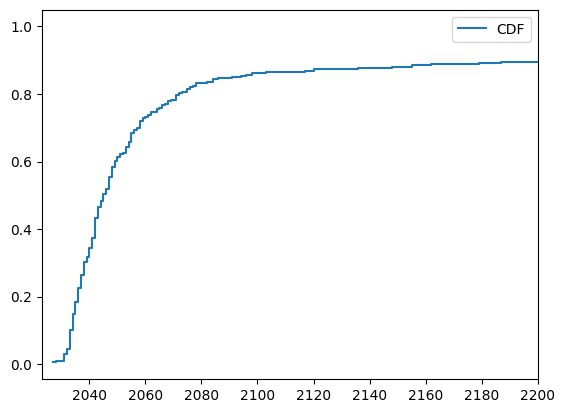

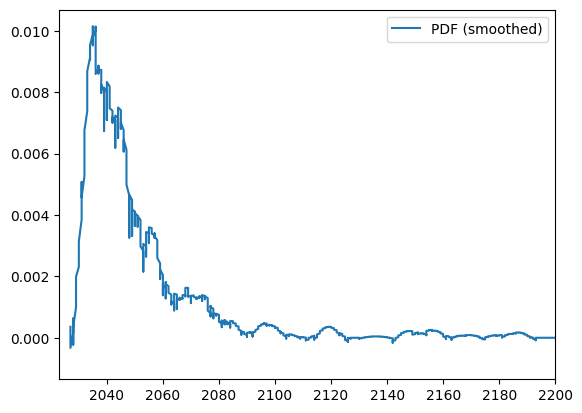

-
-
## TAI FLOP SIZE ##
{1: 23.0,
 5: 24.6,
 10: 25.2,
 20: 26.2,
 30: 27.1,
 40: 27.8,
 50: 29.2,
 60: 30.9,
 70: 32.6,
 80: 35.0,
 90: 38.3,
 95: 40.6,
 99: 44.7}
(Mean: 30.6)


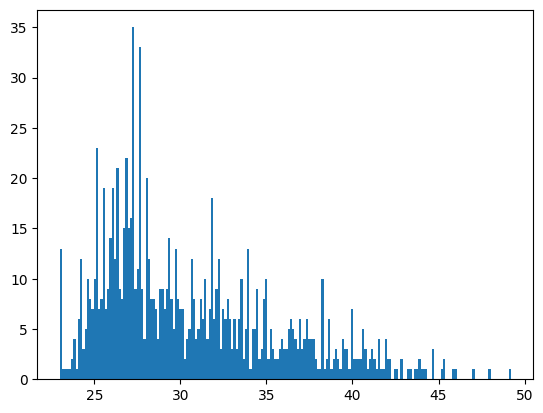

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 19.8,
 5: 14.9,
 10: 12.2,
 20: 10.1,
 30: 8.6,
 40: 7.6,
 50: 6.5,
 60: 5.8,
 70: 5.1,
 80: 4.4,
 90: 3.5,
 95: 3.1,
 99: 2.2}
(Mean: 7.5)


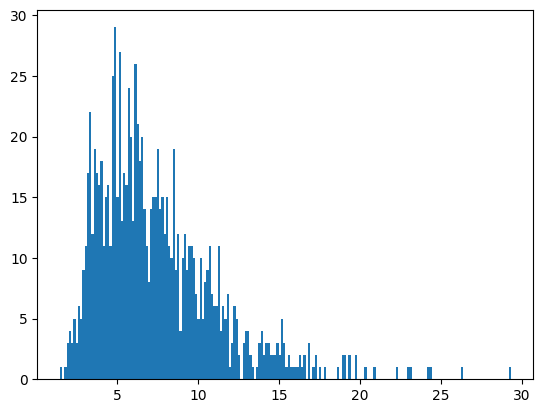

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.9,
 5: 3.5,
 10: 3.3,
 20: 3.0,
 30: 2.8,
 40: 2.6,
 50: 2.5,
 60: 2.3,
 70: 2.1,
 80: 1.9,
 90: 1.7,
 95: 1.5,
 99: 1.1}
(Mean: 2.5)


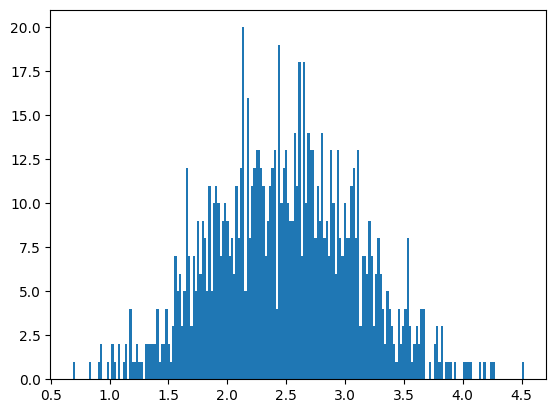

-
-
## MAX FLOP PER DOLLAR ##
{1: 19.9,
 5: 20.9,
 10: 21.5,
 20: 22.2,
 30: 22.7,
 40: 23.0,
 50: 23.4,
 60: 23.8,
 70: 24.2,
 80: 24.7,
 90: 25.4,
 95: 26.0,
 99: 27.2}
(Mean: 23.4)


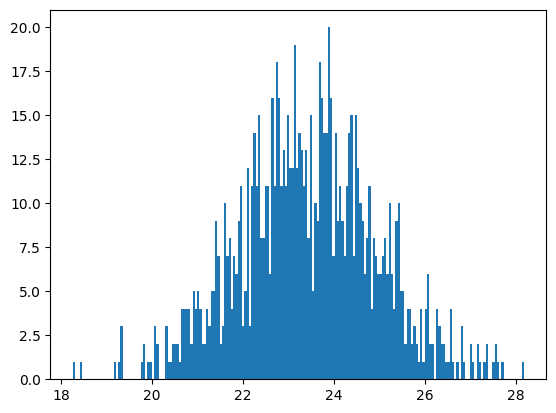

-
-
## INITIAL PAY ##
{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.7,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.6}
(Mean: 8.7)


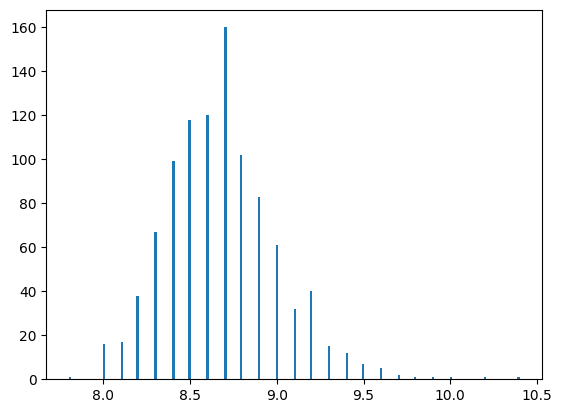

-
-
## GDP GROWTH ##
{1: 1.01,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.04,
 99: 1.04}
(Mean: 1.0)


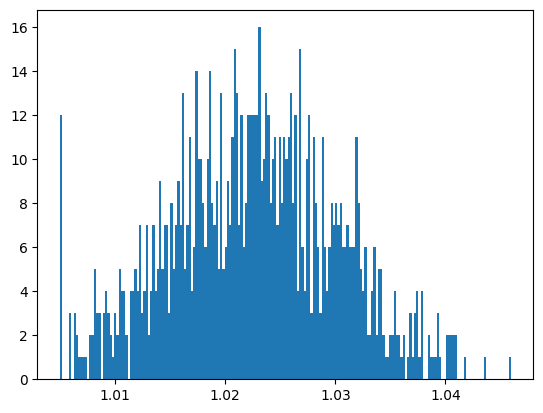

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.0003,
 50: 0.00038,
 60: 0.00048,
 70: 0.00063,
 80: 0.00092,
 90: 0.00188,
 95: 0.00334,
 99: 0.00681}
(Mean: 0.0)


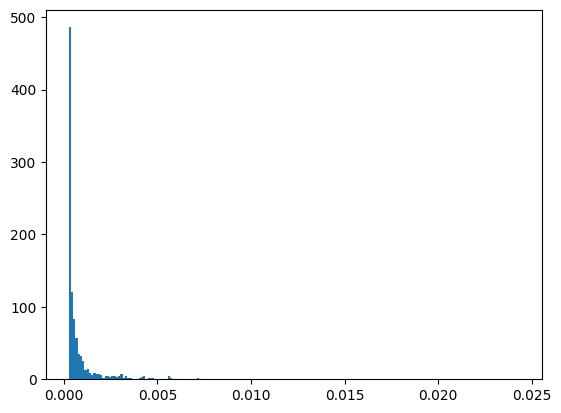

-
-
## SPEND DOUBLING TIME ##
{1: 5.0,
 5: 4.4,
 10: 4.0,
 20: 3.7,
 30: 3.3,
 40: 3.0,
 50: 2.8,
 60: 2.5,
 70: 2.2,
 80: 1.9,
 90: 1.4,
 95: 1.0,
 99: 0.9}
(Mean: 2.8)


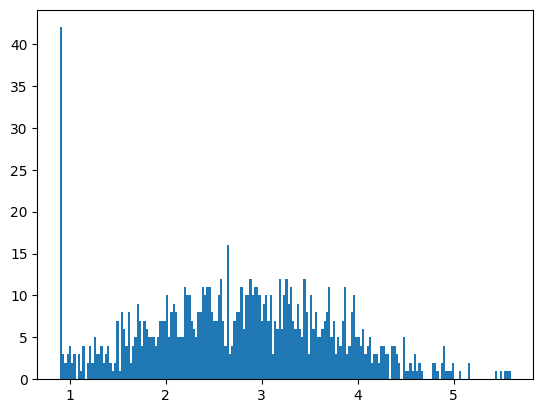

-
-
-
-
## GDP Over Time ##


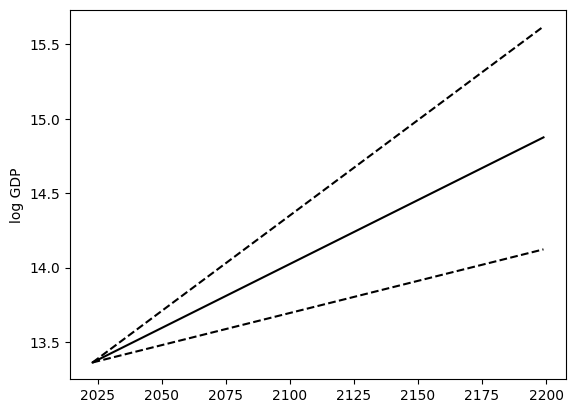

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

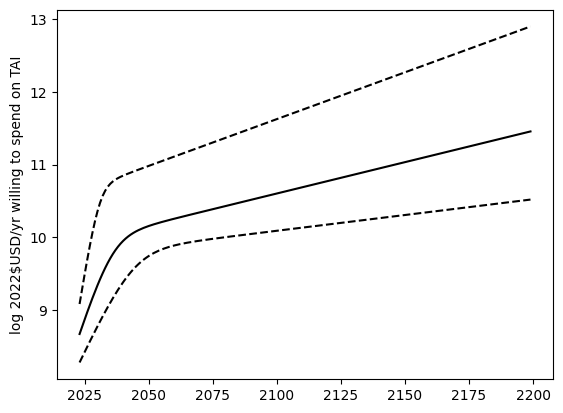

Year: 2023 - willingness log 2022$USD per year 8.7 (~474 million) 90% CI 8.3 (~193 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.8 (~599 million) 90% CI 8.4 (~228 million) - 9.3 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.9 (~754 million) 90% CI 8.4 (~269 million) - 9.5 (~3 billion)
Year: 2026 - willingness log 2022$USD per year 9.0 (~946 million) 90% CI 8.5 (~318 million) - 9.7 (~5 billion)
Year: 2027 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.6 (~374 million) - 9.9 (~8 billion)
Year: 2028 - willingness log 2022$USD per year 9.2 (~1 billion) 90% CI 8.6 (~440 million) - 10.1 (~12 billion)
Year: 2029 - willingness log 2022$USD per year 9.3 (~2 billion) 90% CI 8.7 (~517 million) - 10.2 (~17 billion)
Year: 2030 - willingness log 2022$USD per year 9.3 (~2 billion) 90% CI 8.8 (~605 million) - 10.4 (~23 billion)
Year: 2031 - willingness log 2022$USD per year 9.4 (~3 billion) 90% CI 8.8 (~707 million) - 10.5 (~30 billion)
Yea

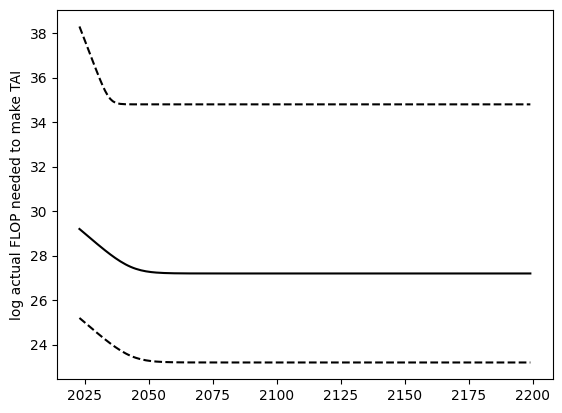

Year: 2023 - log FLOP needed for TAI 29.2 (~158 octillion) 90% CI 25.2 (~16 septillion) - 38.3 (~200 thousand decillion)
Year: 2024 - log FLOP needed for TAI 29.1 (~127 octillion) 90% CI 25.1 (~13 septillion) - 38.0 (~100 thousand decillion)
Year: 2025 - log FLOP needed for TAI 29.0 (~101 octillion) 90% CI 25.0 (~10 septillion) - 37.7 (~50 thousand decillion)
Year: 2026 - log FLOP needed for TAI 28.9 (~81 octillion) 90% CI 24.9 (~8 septillion) - 37.4 (~25 thousand decillion)
Year: 2027 - log FLOP needed for TAI 28.8 (~64 octillion) 90% CI 24.8 (~6 septillion) - 37.1 (~13 thousand decillion)
Year: 2028 - log FLOP needed for TAI 28.7 (~52 octillion) 90% CI 24.7 (~5 septillion) - 36.8 (~6 thousand decillion)
Year: 2029 - log FLOP needed for TAI 28.6 (~41 octillion) 90% CI 24.6 (~4 septillion) - 36.5 (~3 thousand decillion)
Year: 2030 - log FLOP needed for TAI 28.5 (~33 octillion) 90% CI 24.5 (~3 septillion) - 36.2 (~2 thousand decillion)
Year: 2031 - log FLOP needed for TAI 28.4 (~27 octi

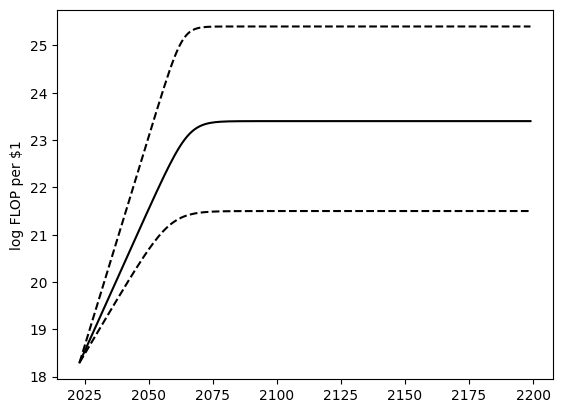

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~2 quintillion) - 18.5 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.7 (~5 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.8 (~7 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 19.0 (~10 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~6 quintillion) - 19.2 (~15 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.8 (~7 quintillion) - 19.4 (~23 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 18.9 (~9 quintillion) - 19.5 (~35 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.0 (~11 quintillion) - 19.7 (~52 quint

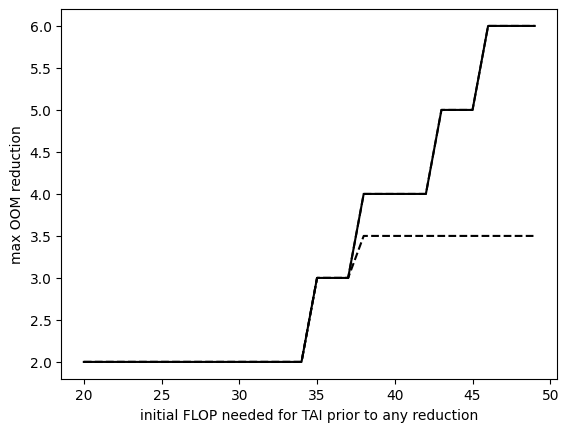

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

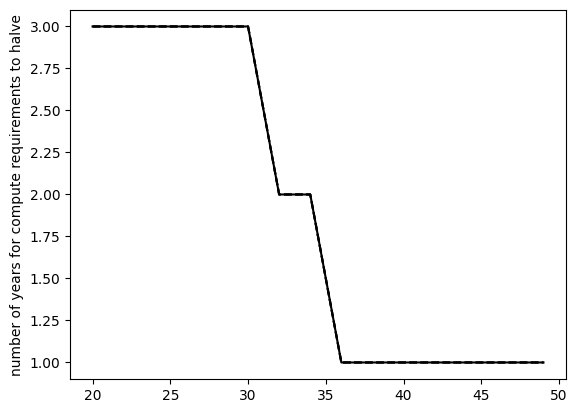

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

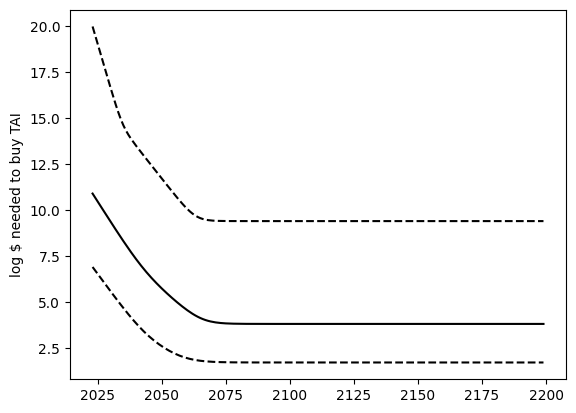

Year: 2023 - 10.9 log 2022$USD to buy TAI (~79 billion) 90% CI 6.9 (~8 million) - 20.0 (~100 quintillion)
Year: 2024 - 10.7 log 2022$USD to buy TAI (~48 billion) 90% CI 6.7 (~5 million) - 19.5 (~33 quintillion)
Year: 2025 - 10.5 log 2022$USD to buy TAI (~29 billion) 90% CI 6.5 (~3 million) - 19.0 (~11 quintillion)
Year: 2026 - 10.2 log 2022$USD to buy TAI (~18 billion) 90% CI 6.3 (~2 million) - 18.6 (~4 quintillion)
Year: 2027 - 10.0 log 2022$USD to buy TAI (~11 billion) 90% CI 6.1 (~1 million) - 18.1 (~1 quintillion)
Year: 2028 - 9.8 log 2022$USD to buy TAI (~6 billion) 90% CI 6.0 (~905 thousand) - 17.6 (~411 quadrillion)
Year: 2029 - 9.6 log 2022$USD to buy TAI (~4 billion) 90% CI 5.8 (~587 thousand) - 17.1 (~138 quadrillion)
Year: 2030 - 9.4 log 2022$USD to buy TAI (~2 billion) 90% CI 5.6 (~382 thousand) - 16.7 (~47 quadrillion)
Year: 2031 - 9.2 log 2022$USD to buy TAI (~1 billion) 90% CI 5.4 (~249 thousand) - 16.2 (~16 quadrillion)
Year: 2032 - 8.9 log 2022$USD to buy TAI (~884 mil

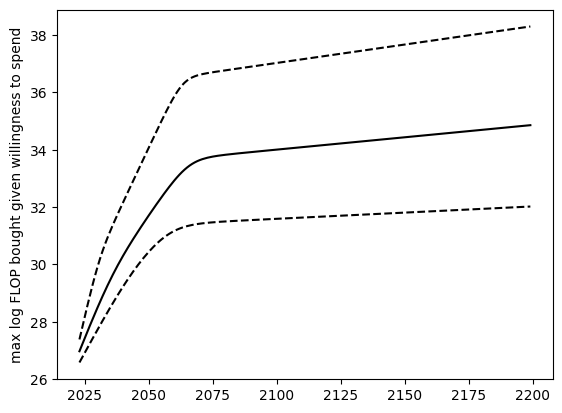

Year: 2023 - max log FLOP 27.0 (~946 septillion) 90% CI 26.6 (~385 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log FLOP 27.2 (~2 octillion) 90% CI 26.7 (~561 septillion) - 27.8 (~6 octillion)
Year: 2025 - max log FLOP 27.4 (~3 octillion) 90% CI 26.9 (~817 septillion) - 28.2 (~14 octillion)
Year: 2026 - max log FLOP 27.6 (~4 octillion) 90% CI 27.1 (~1 octillion) - 28.5 (~34 octillion)
Year: 2027 - max log FLOP 27.9 (~7 octillion) 90% CI 27.2 (~2 octillion) - 28.9 (~78 octillion)
Year: 2028 - max log FLOP 28.1 (~12 octillion) 90% CI 27.4 (~3 octillion) - 29.2 (~177 octillion)
Year: 2029 - max log FLOP 28.3 (~19 octillion) 90% CI 27.6 (~4 octillion) - 29.6 (~383 octillion)
Year: 2030 - max log FLOP 28.5 (~31 octillion) 90% CI 27.7 (~5 octillion) - 29.9 (~794 octillion)
Year: 2031 - max log FLOP 28.7 (~49 octillion) 90% CI 27.9 (~8 octillion) - 30.2 (~2 nonillion)
Year: 2032 - max log FLOP 28.9 (~78 octillion) 90% CI 28.0 (~11 octillion) - 30.5 (~3 nonillion)
Year: 2033 - max log FL

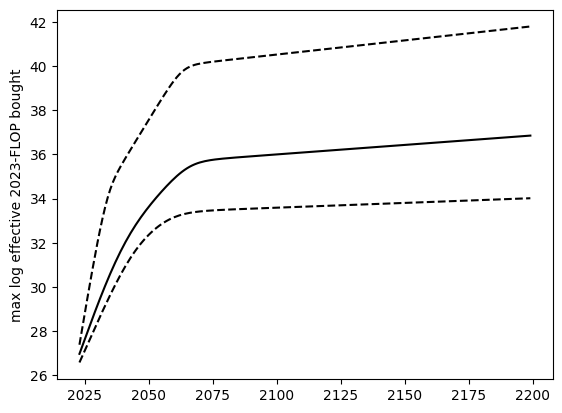

Year: 2023 - max log effective 2023-FLOP 27.0 (~946 septillion) 90% CI 26.6 (~385 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log effective 2023-FLOP 27.3 (~2 octillion) 90% CI 26.8 (~698 septillion) - 28.1 (~12 octillion)
Year: 2025 - max log effective 2023-FLOP 27.6 (~4 octillion) 90% CI 27.1 (~1 octillion) - 28.8 (~57 octillion)
Year: 2026 - max log effective 2023-FLOP 27.9 (~9 octillion) 90% CI 27.4 (~2 octillion) - 29.4 (~269 octillion)
Year: 2027 - max log effective 2023-FLOP 28.2 (~18 octillion) 90% CI 27.6 (~4 octillion) - 30.1 (~1 nonillion)
Year: 2028 - max log effective 2023-FLOP 28.6 (~36 octillion) 90% CI 27.9 (~8 octillion) - 30.7 (~6 nonillion)
Year: 2029 - max log effective 2023-FLOP 28.9 (~73 octillion) 90% CI 28.1 (~14 octillion) - 31.4 (~24 nonillion)
Year: 2030 - max log effective 2023-FLOP 29.2 (~147 octillion) 90% CI 28.4 (~25 octillion) - 32.0 (~98 nonillion)
Year: 2031 - max log effective 2023-FLOP 29.5 (~293 octillion) 90% CI 28.7 (~45 octillion) - 32.6 

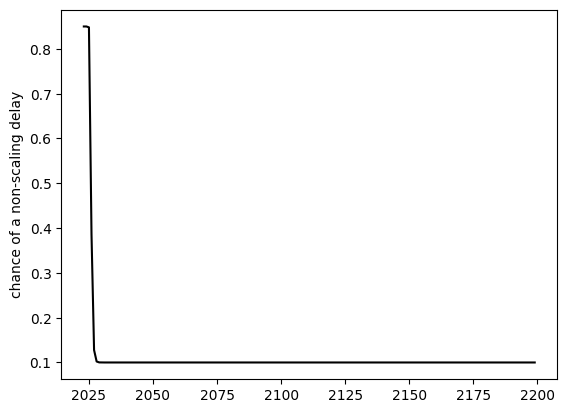

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

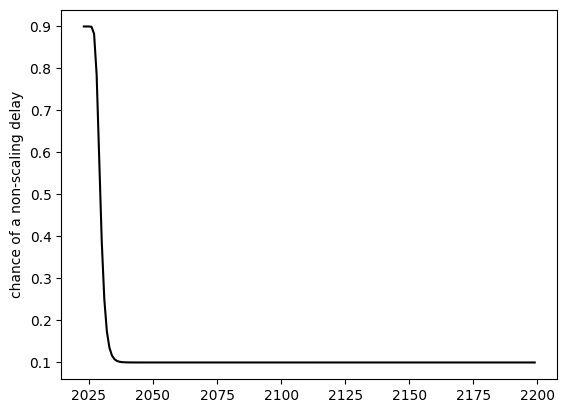

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 88%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 79%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2033

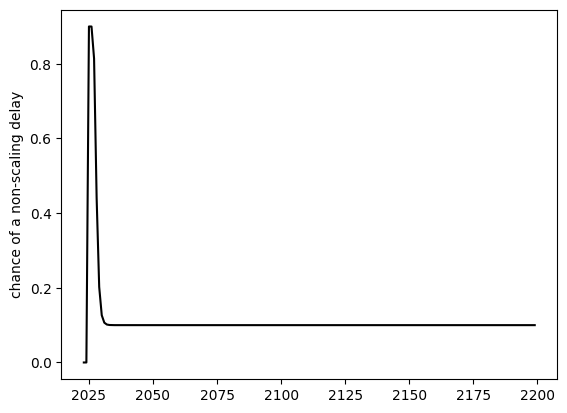

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 81%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 44%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033 -

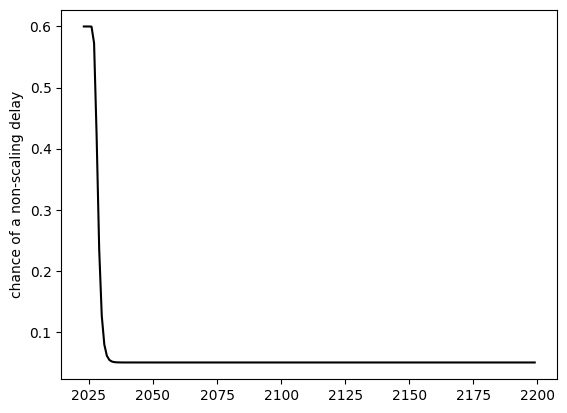

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 42%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2033 -

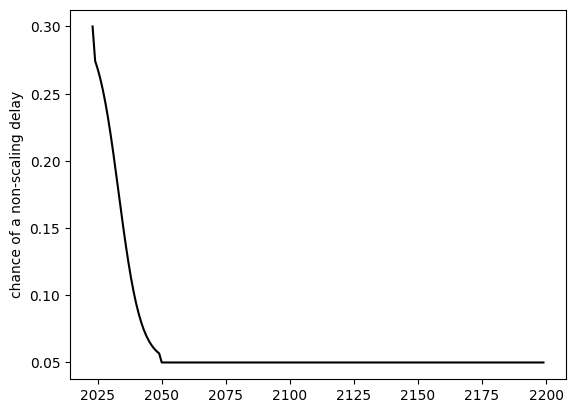

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2033

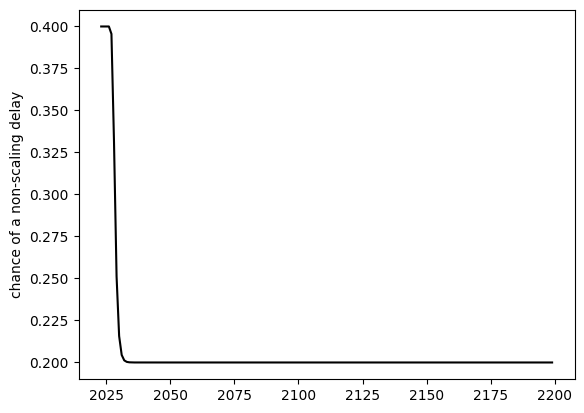

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 33%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2033

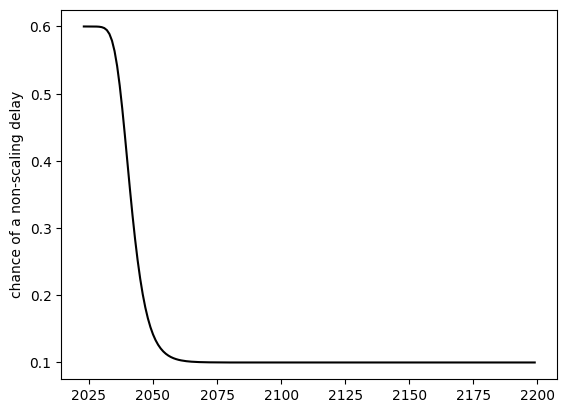

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2033

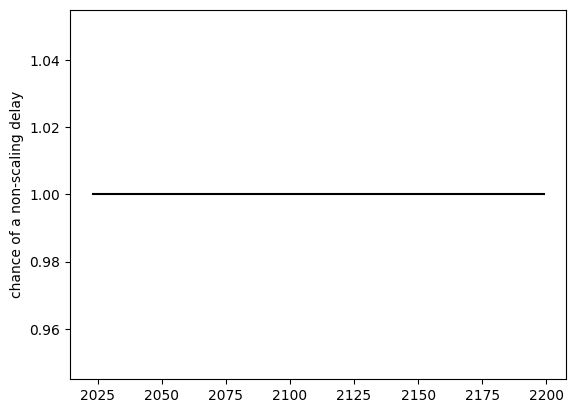

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%


/Users/peterhurford/.virtualenvs/dev/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/peterhurford/.virtualenvs/dev/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 24.7 log FLOP (~5 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 2.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 24.7 log FLOP (5 septillion) - log $ 6.4 to buy TAI (3 million) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 1 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur

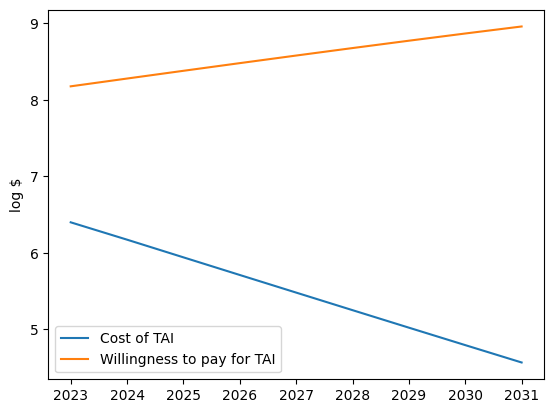

-
-
## SAMPLE RUN 5 ##
It takes 33.2 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~184 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 2.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 33.2 log FLOP (2 decillion) - log $ 14.9 to buy TAI (794 trillion) vs. willingness to pay log $ 8.9 (742 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 33.1 log FLOP (1 decillion) - log $ 14.6 to buy TAI (431 trillion) vs. willingness to pay log $ 9.0 (967 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.3)

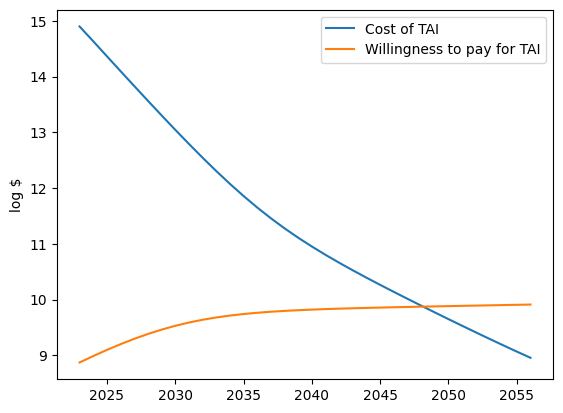

-
-
## SAMPLE RUN 6 ##
It takes 25.5 log FLOP (~32 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~124 million). This doubles every 4.0 years to a max of 0.028435% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.4 max log FLOP (242 septillion) available - TAI takes 25.5 log FLOP (32 septillion) - log $ 7.2 to buy TAI (16 million) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 9 years (total delay 9 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 10 years)
-- data p_nons

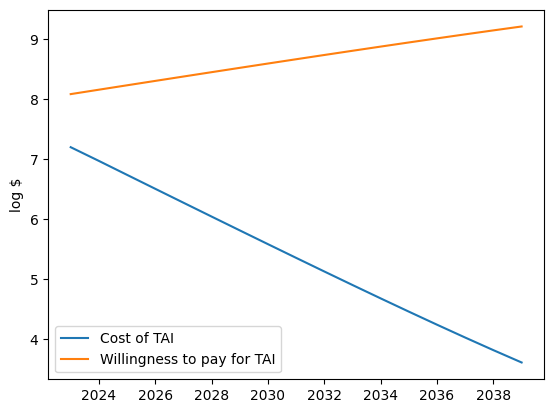

-
-
## SAMPLE RUN 7 ##
It takes 25.1 log FLOP (~13 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~244 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~157 million). This doubles every 4.6 years to a max of 0.054315% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.5 max log FLOP (308 septillion) available - TAI takes 25.1 log FLOP (13 septillion) - log $ 6.8 to buy TAI (6 million) vs. willingness to pay log $ 8.2 (155 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did no

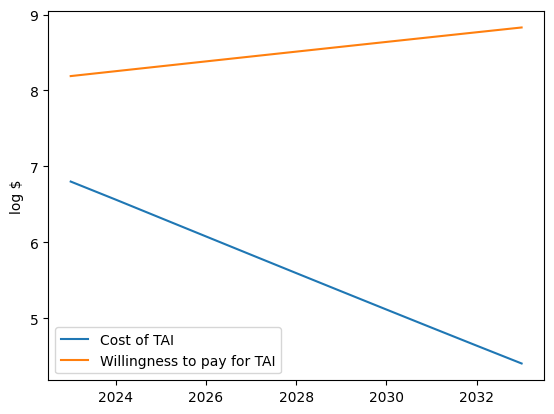

-
-
## SAMPLE RUN 8 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~745 million). This doubles every 2.5 years to a max of 0.051918% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.6 to buy TAI (398 million) vs. willingness to pay log $ 8.8 (701 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 29 years (total delay 29 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 30 years)
-- data p_non

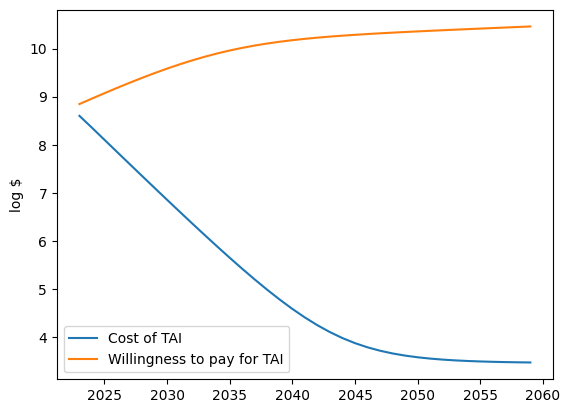

-
-
## SAMPLE RUN 9 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~453 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~196 million). This doubles every 2.9 years to a max of 0.053079% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.6 max log FLOP (386 septillion) available - TAI takes 26.8 log FLOP (631 septillion) - log $ 8.5 to buy TAI (316 million) vs. willingness to pay log $ 8.3 (193 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (665 septillion) available - TAI takes 26.7 log FLOP (507 septillion) - log $ 8.3 to buy TAI (186 million) vs. willingness to pay log $ 8.4 (244 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-lo

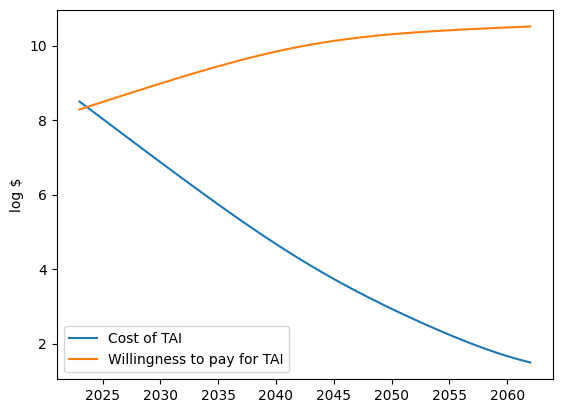

-
-
## SAMPLE RUN 10 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.02507% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.9 max log FLOP (852 septillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.6 to buy TAI (398 million) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 12 years (total delay 12 years)
-- data p_

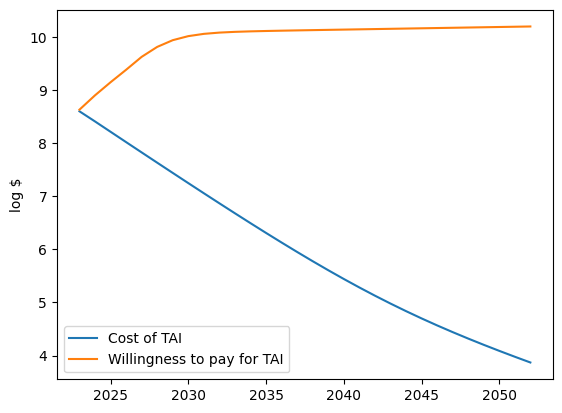

-
-
## SAMPLE RUN 11 ##
It takes 41.3 log FLOP (~200 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~192 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~199 million). This doubles every 3.5 years to a max of 0.233437% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.6 max log FLOP (395 septillion) available - TAI takes 41.3 log FLOP (200 million decillion) - log $ 23.0 to buy TAI (100 sextillion) vs. willingness to pay log $ 8.3 (198 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (681 septillion) available - TAI takes 41.0 log FLOP (100 million decillion) - log $ 22.5 to buy TAI (35 sextillion) vs. willingness to pay log $ 8.4 (241 million) - 18.5 log FLOP per $ (3 qu

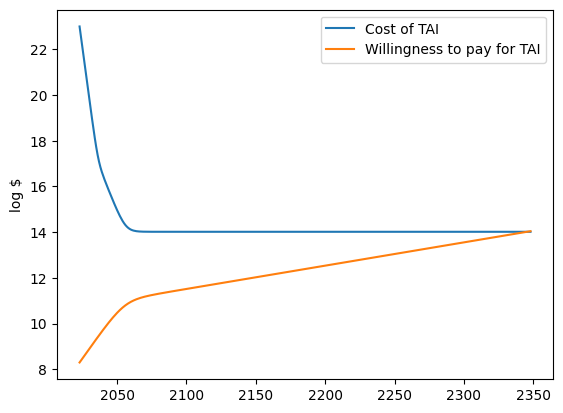

-
-
## SAMPLE RUN 12 ##
It takes 26.5 log FLOP (~316 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~194 million). This doubles every 2.5 years to a max of 0.029977% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.6 max log FLOP (376 septillion) available - TAI takes 26.5 log FLOP (316 septillion) - log $ 8.2 to buy TAI (159 million) vs. willingness to pay log $ 8.3 (189 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 6 years)
-- data p_no

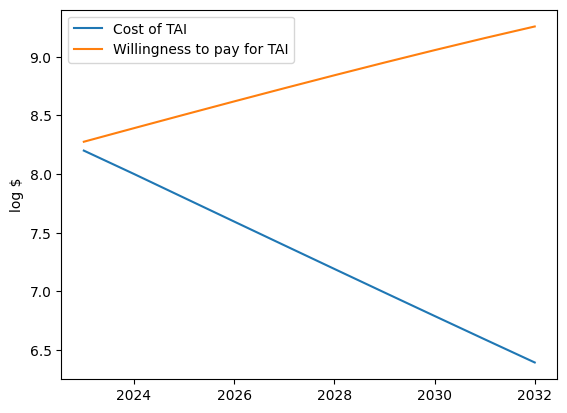

-
-
## SAMPLE RUN 13 ##
It takes 26.6 log FLOP (~398 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 5.8 years to a max of 0.025% of GDP. GDP grows at a rate of 1.007x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 26.6 log FLOP (398 septillion) - log $ 8.3 to buy TAI (200 million) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 4 years)
-- data p_nonscali

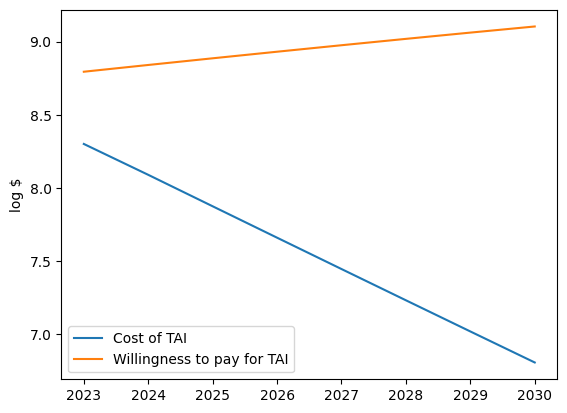

-
-
## SAMPLE RUN 14 ##
It takes 28.0 log FLOP (~10 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.5 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~761 million). This doubles every 4.1 years to a max of 0.078192% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 8.9 (730 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.4 to buy TAI (3 billion) vs. willingness to pay log $ 8.9 (858 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)
Year

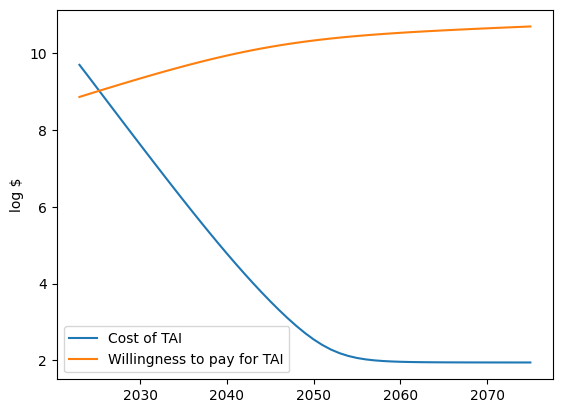

-
-
## SAMPLE RUN 15 ##
It takes 26.0 log FLOP (~100 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~160 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~242 million). This doubles every 5.1 years to a max of 0.027652% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.7 max log FLOP (464 septillion) available - TAI takes 26.0 log FLOP (100 septillion) - log $ 7.7 to buy TAI (50 million) vs. willingness to pay log $ 8.4 (233 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue di

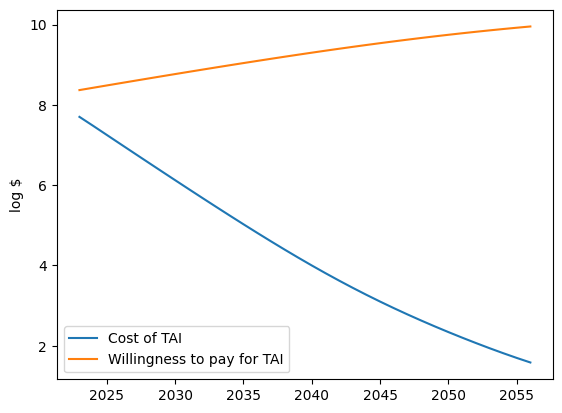

-
-
## SAMPLE RUN 16 ##
It takes 35.8 log FLOP (~631 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~16 septillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.065677% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.5 to buy TAI (316 quadrillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 35.6 log FLOP (398 decillion) - log $ 17.2 to buy TAI (154 quadrillion) vs. willingness to pay log $ 9.3 (2 billion) - 18.4 log FLO

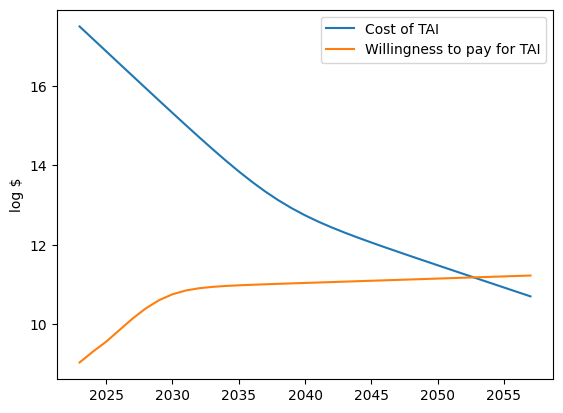

-
-
## SAMPLE RUN 17 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~514 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 3.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 26.8 log FLOP (631 septillion) - log $ 8.5 to buy TAI (316 million) vs. willingness to pay log $ 8.9 (742 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 6 years)
-- data p_nonsca

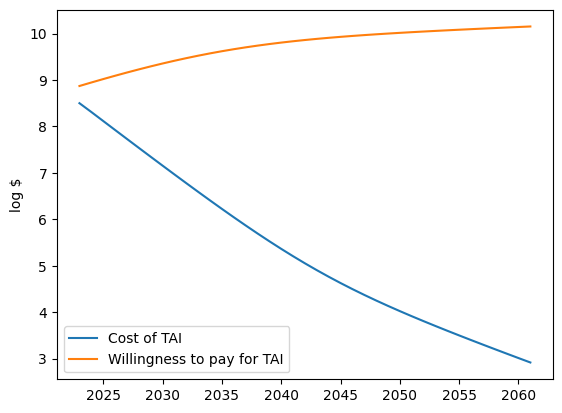

-
-
## SAMPLE RUN 18 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 20.3 log FLOP (~189 quintillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 1.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 26.8 log FLOP (631 septillion) - log $ 8.5 to buy TAI (320 million) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did no

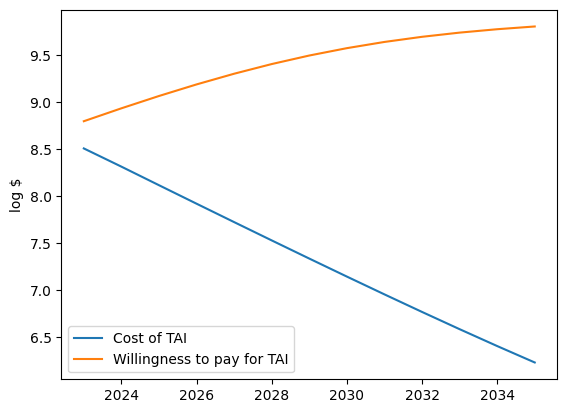

-
-
## SAMPLE RUN 19 ##
It takes 25.5 log FLOP (~32 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~57 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~593 million). This doubles every 2.7 years to a max of 0.042328% of GDP. GDP grows at a rate of 1.041x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 25.5 log FLOP (32 septillion) - log $ 7.2 to buy TAI (16 million) vs. willingness to pay log $ 8.7 (559 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 6 years)
-- data p_nonscal

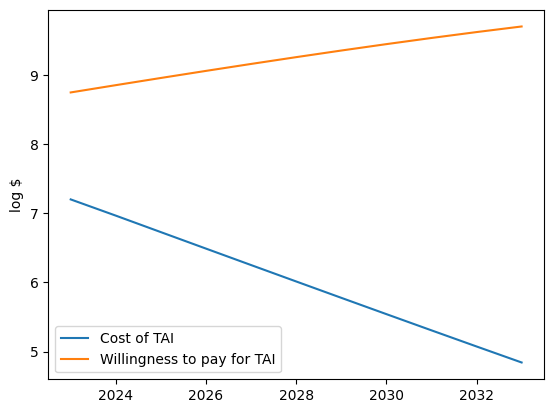

-
-
## SAMPLE RUN 20 ##
It takes 27.3 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~17 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~157 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.079272% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.5 max log FLOP (311 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 8.2 (156 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.9 max log FLOP (777 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.8 to buy TAI (652 million) vs. willingness to pay log $ 8.5 (316 million) - 18.4 log FLOP per $ 

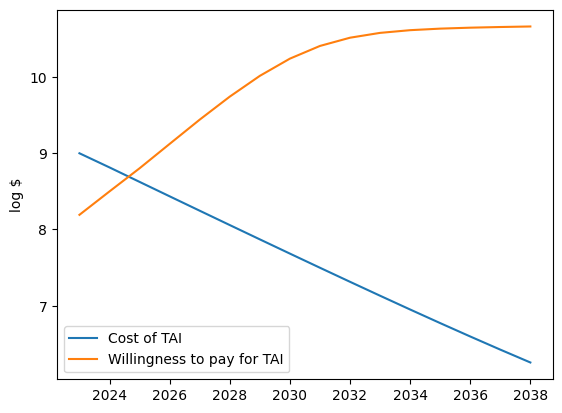

-
-
## SAMPLE RUN 21 ##
It takes 36.1 log FLOP (~1 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~710 million). This doubles every 3.1 years to a max of 0.029174% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.8 to buy TAI (631 quadrillion) vs. willingness to pay log $ 8.8 (642 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.3 to buy TAI (219 quadrillion) vs. willingness to pay log $ 8.9 (785 million) - 18.5 log FLOP per $ (3 quintillion) (E

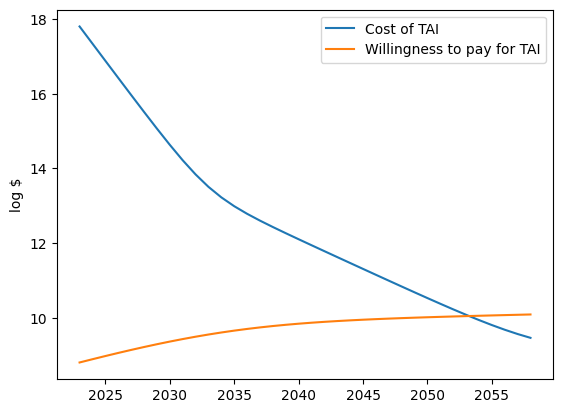

-
-
## SAMPLE RUN 22 ##
It takes 24.8 log FLOP (~6 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~9 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 24.8 log FLOP (6 septillion) - log $ 6.5 to buy TAI (3 million) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_is

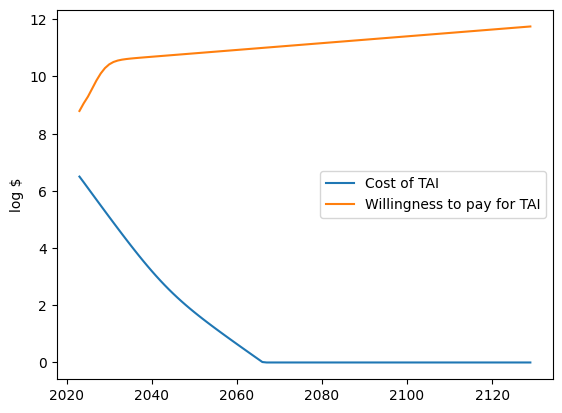

-
-
## SAMPLE RUN 23 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~77 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~712 million). This doubles every 2.5 years to a max of 0.029869% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.6 to buy TAI (398 million) vs. willingness to pay log $ 8.8 (645 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nons

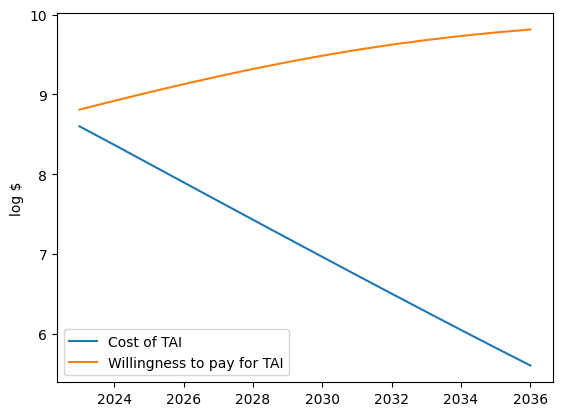

-
-
## SAMPLE RUN 24 ##
It takes 32.0 log FLOP (~100 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 19.9 log FLOP (~74 quintillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~1 billion). This doubles every 2.7 years to a max of 0.104965% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 32.0 log FLOP (100 nonillion) - log $ 13.7 to buy TAI (51 trillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 31.9 log FLOP (72 nonillion) - log $ 13.5 to buy TAI (29 trillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.5

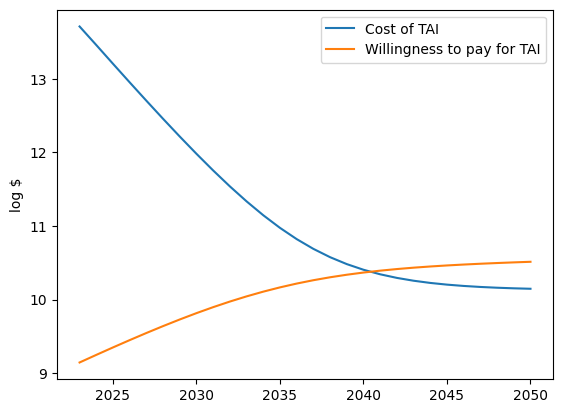

-
-
## SAMPLE RUN 25 ##
It takes 31.7 log FLOP (~50 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~95 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~571 million). This doubles every 2.8 years to a max of 0.026281% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 31.7 log FLOP (50 nonillion) - log $ 13.4 to buy TAI (25 trillion) vs. willingness to pay log $ 8.7 (522 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 31.6 log FLOP (38 nonillion) - log $ 13.2 to buy TAI (15 trillion) vs. willingness to pay log $ 8.8 (656 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

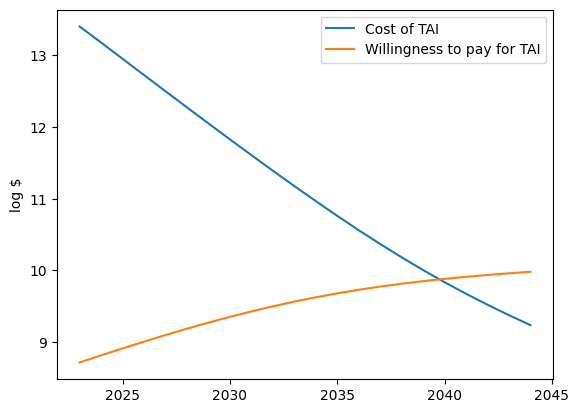

-
-
## SAMPLE RUN 26 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~994 million). This doubles every 2.1 years to a max of 0.774594% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 9.0 (989 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.4 to buy TAI (2 billion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 20

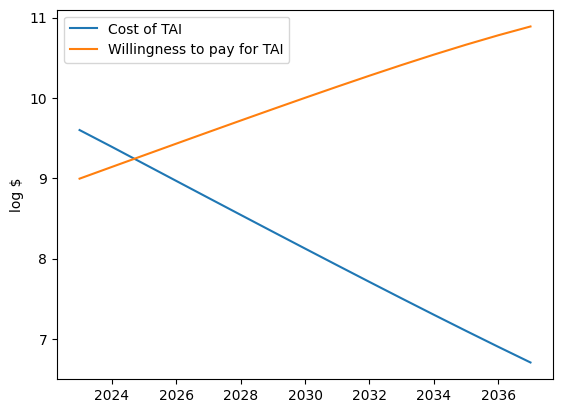

-
-
## SAMPLE RUN 27 ##
It takes 28.2 log FLOP (~16 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5 septillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 1.4 years to a max of 0.072536% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.4 max log FLOP (247 septillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.9 to buy TAI (8 billion) vs. willingness to pay log $ 8.1 (124 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.8 max log FLOP (565 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 8.3 (200 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26

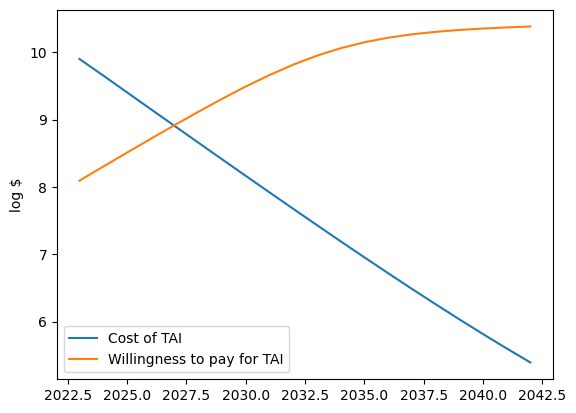

-
-
## SAMPLE RUN 28 ##
It takes 25.4 log FLOP (~25 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 26.5 log FLOP (~348 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 2.8 years to a max of 0.025% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 25.4 log FLOP (25 septillion) - log $ 7.1 to buy TAI (13 million) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occ

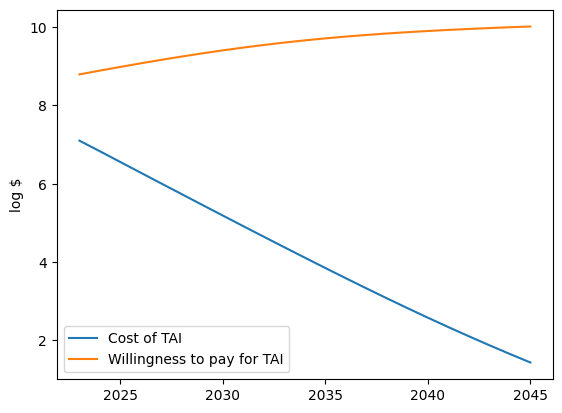

-
-
## SAMPLE RUN 29 ##
It takes 27.5 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~613 million). This doubles every 4.2 years to a max of 0.091651% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 8.8 (595 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 8.8 (698 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2

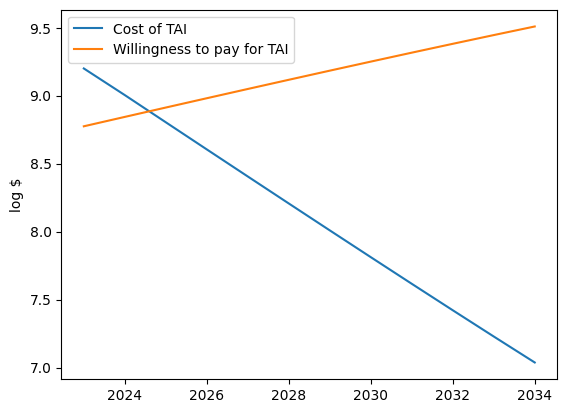

-
-
## SAMPLE RUN 30 ##
It takes 31.1 log FLOP (~13 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 25.9 log FLOP (~87 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~195 million). This doubles every 3.3 years to a max of 0.040295% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.6 max log FLOP (382 septillion) available - TAI takes 31.1 log FLOP (13 nonillion) - log $ 12.8 to buy TAI (6 trillion) vs. willingness to pay log $ 8.3 (191 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (659 septillion) available - TAI takes 31.0 log FLOP (10 nonillion) - log $ 12.5 to buy TAI (3 trillion) vs. willingness to pay log $ 8.4 (235 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLO

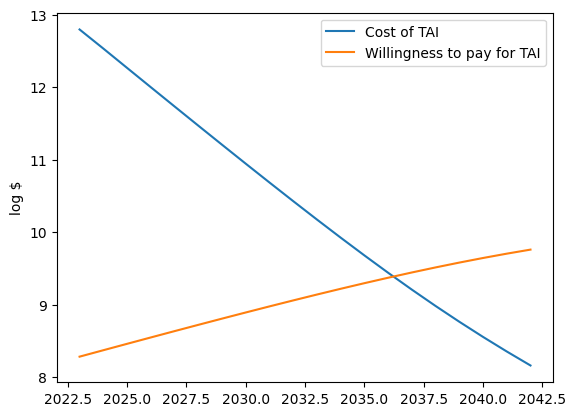

-
-
## SAMPLE RUN 31 ##
It takes 34.1 log FLOP (~13 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~751 million). This doubles every 1.9 years to a max of 0.059976% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 34.1 log FLOP (13 decillion) - log $ 15.8 to buy TAI (6 quadrillion) vs. willingness to pay log $ 8.9 (712 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 33.9 log FLOP (8 decillion) - log $ 15.4 to buy TAI (3 quadrillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

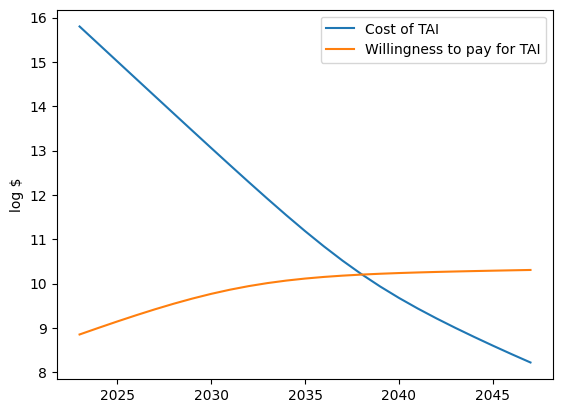

-
-
## SAMPLE RUN 32 ##
It takes 39.0 log FLOP (~1 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~608 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.071797% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 39.0 log FLOP (1 million decillion) - log $ 20.7 to buy TAI (501 quintillion) vs. willingness to pay log $ 8.8 (586 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 38.7 log FLOP (500 thousand decillion) - log $ 20.3 to buy TAI (195 quintillion) vs. willingness to pay log $ 9.1 (1 b

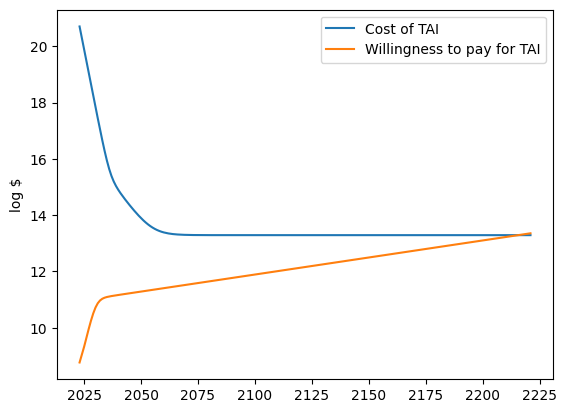

-
-
## SAMPLE RUN 33 ##
It takes 26.4 log FLOP (~251 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~386 million). This doubles every 4.3 years to a max of 0.057528% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.9 max log FLOP (749 septillion) available - TAI takes 26.4 log FLOP (251 septillion) - log $ 8.1 to buy TAI (126 million) vs. willingness to pay log $ 8.6 (376 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 1 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did

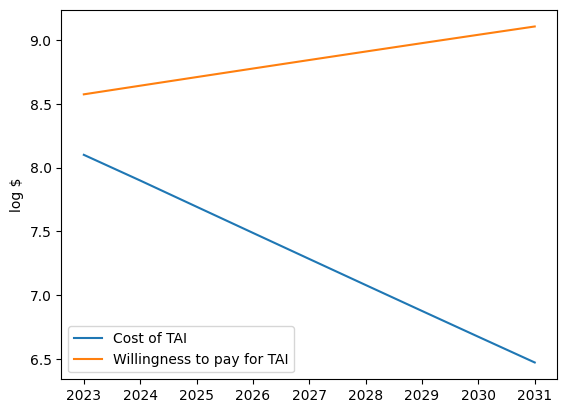

-
-
## SAMPLE RUN 34 ##
It takes 27.7 log FLOP (~5 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.3 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~957 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~246 million). This doubles every 2.8 years to a max of 0.05621% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.7 max log FLOP (482 septillion) available - TAI takes 27.7 log FLOP (5 octillion) - log $ 9.4 to buy TAI (3 billion) vs. willingness to pay log $ 8.4 (242 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.5 (308 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.1)
Yea

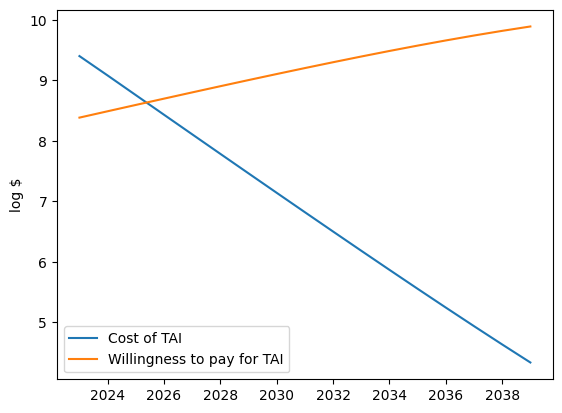

-
-
## SAMPLE RUN 35 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~999 quintillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 4.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.9 max log FLOP (850 septillion) available - TAI takes 26.2 log FLOP (158 septillion) - log $ 7.9 to buy TAI (80 million) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 25 years (total delay 31 years)
-- data p_n

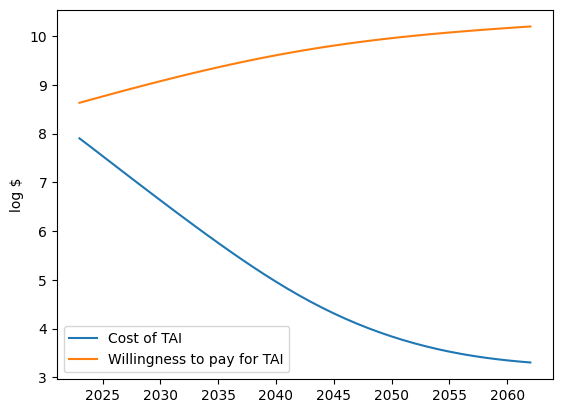

-
-
## SAMPLE RUN 36 ##
It takes 27.8 log FLOP (~6 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 1.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 27.7 log FLOP (5 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 8.7 (506 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2

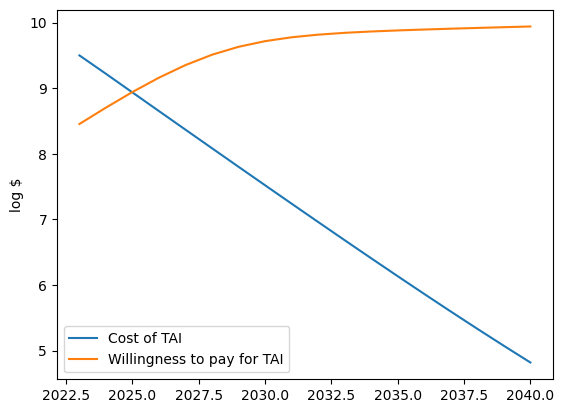

-
-
## SAMPLE RUN 37 ##
It takes 42.9 log FLOP (~8 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~532 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 2.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.6 max log FLOP (372 septillion) available - TAI takes 42.9 log FLOP (8 billion decillion) - log $ 24.6 to buy TAI (4 septillion) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (631 septillion) available - TAI takes 42.6 log FLOP (4 billion decillion) - log $ 24.2 to buy TAI (2 septillion) vs. willingness to pay log $ 8.4 (255 million) - 18.4 log FLOP per $ (2 quintillion) (

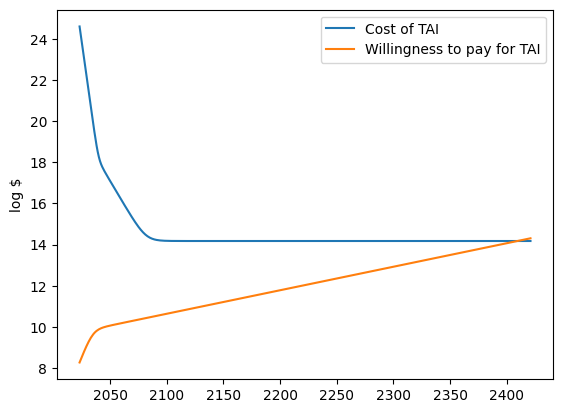

-
-
## SAMPLE RUN 38 ##
It takes 33.9 log FLOP (~8 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~877 million). This doubles every 5.0 years to a max of 0.031023% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 33.9 log FLOP (8 decillion) - log $ 15.6 to buy TAI (4 quadrillion) vs. willingness to pay log $ 8.9 (781 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 33.8 log FLOP (6 decillion) - log $ 15.3 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.9 (886 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

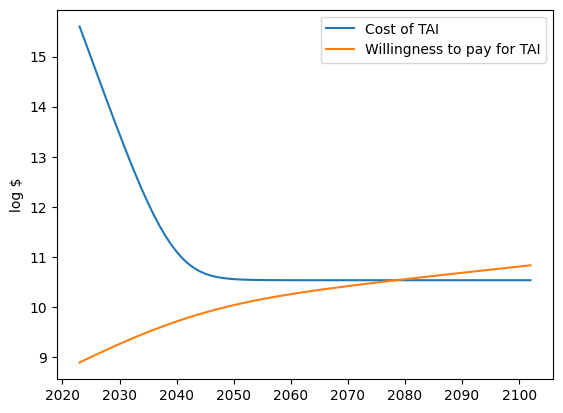

-
-
## SAMPLE RUN 39 ##
It takes 30.3 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 2.8 years to a max of 0.025% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 12.0 to buy TAI (1 trillion) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (747 septillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.8 to buy TAI (600 billion) vs. willingness to pay log $ 8.5 (292 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.

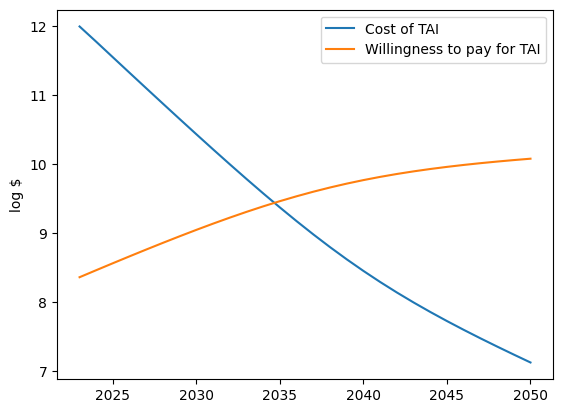

-
-
## SAMPLE RUN 40 ##
It takes 34.6 log FLOP (~40 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~484 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~199 million). This doubles every 1.9 years to a max of 0.512677% of GDP. GDP grows at a rate of 1.009x per year.
---
Year: 2023 - 26.6 max log FLOP (397 septillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 16.3 to buy TAI (20 quadrillion) vs. willingness to pay log $ 8.3 (199 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.9 max log FLOP (804 septillion) available - TAI takes 34.4 log FLOP (25 decillion) - log $ 16.0 to buy TAI (9 quadrillion) vs. willingness to pay log $ 8.5 (288 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 202

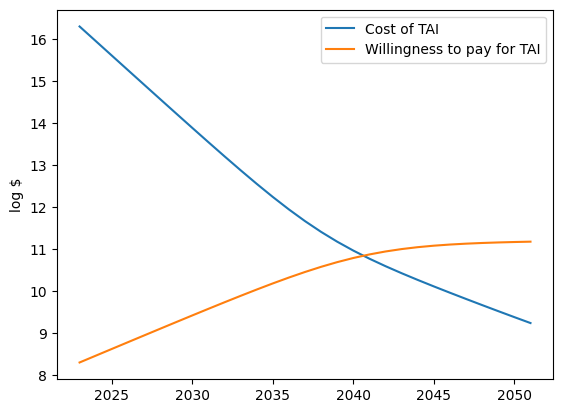

-
-
## SAMPLE RUN 41 ##
It takes 32.4 log FLOP (~251 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~611 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.031748% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 32.4 log FLOP (251 nonillion) - log $ 14.1 to buy TAI (126 trillion) vs. willingness to pay log $ 9.0 (936 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 32.3 log FLOP (180 nonillion) - log $ 13.8 to buy TAI (66 trillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.4 log FLOP pe

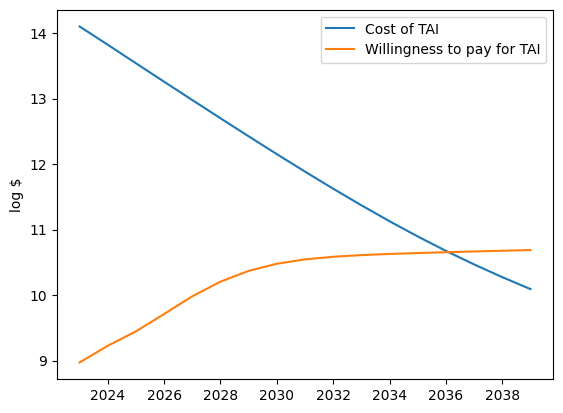

-
-
## SAMPLE RUN 42 ##
It takes 32.5 log FLOP (~316 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 26.2 log FLOP (~168 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 3.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.6 max log FLOP (372 septillion) available - TAI takes 32.5 log FLOP (316 nonillion) - log $ 14.2 to buy TAI (158 trillion) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (666 septillion) available - TAI takes 32.4 log FLOP (227 nonillion) - log $ 13.9 to buy TAI (79 trillion) vs. willingness to pay log $ 8.4 (233 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-lo

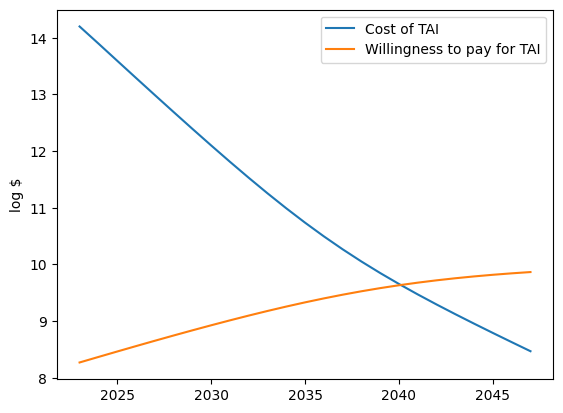

-
-
## SAMPLE RUN 43 ##
It takes 36.9 log FLOP (~8 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 3.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 36.9 log FLOP (8 thousand decillion) - log $ 18.6 to buy TAI (4 quintillion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 36.6 log FLOP (4 thousand decillion) - log $ 18.1 to buy TAI (1 quintillion) vs. willingness to pay log $ 8.5 (344 million) - 18.5 log FLOP per $ (3 quintillion)

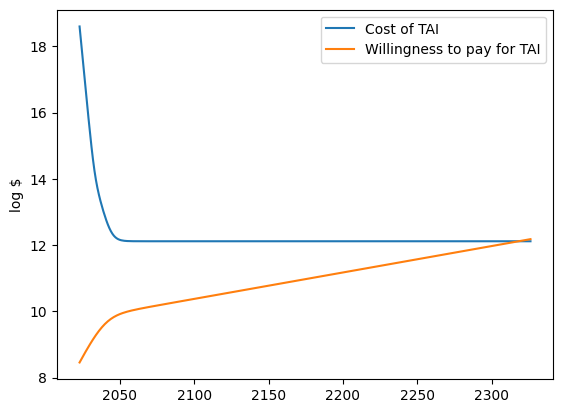

-
-
## SAMPLE RUN 44 ##
It takes 34.6 log FLOP (~40 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~32 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~490 million). This doubles every 2.6 years to a max of 0.099239% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.0 max log FLOP (958 septillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 16.3 to buy TAI (20 quadrillion) vs. willingness to pay log $ 8.7 (480 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 34.4 log FLOP (25 decillion) - log $ 16.0 to buy TAI (10 quadrillion) vs. willingness to pay log $ 8.8 (623 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-l

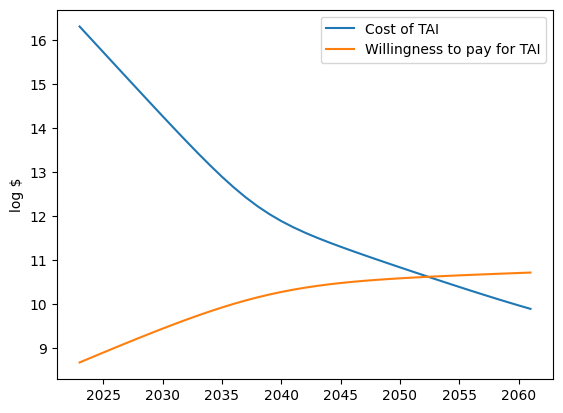

-
-
## SAMPLE RUN 45 ##
It takes 29.3 log FLOP (~200 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~246 million). This doubles every 4.1 years to a max of 0.0503% of GDP. GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 26.7 max log FLOP (480 septillion) available - TAI takes 29.3 log FLOP (200 octillion) - log $ 11.0 to buy TAI (100 billion) vs. willingness to pay log $ 8.4 (241 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.8 max log FLOP (701 septillion) available - TAI takes 29.2 log FLOP (160 octillion) - log $ 10.8 to buy TAI (65 billion) vs. willingness to pay log $ 8.5 (284 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFL

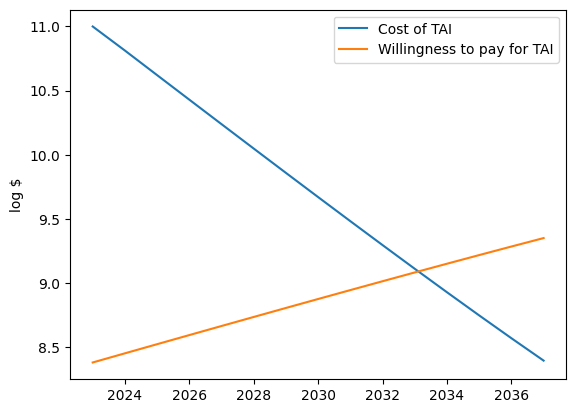

-
-
## SAMPLE RUN 46 ##
It takes 33.9 log FLOP (~8 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~149 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~312 million). This doubles every 1.4 years to a max of 0.10026% of GDP. GDP grows at a rate of 1.039x per year.
---
Year: 2023 - 26.8 max log FLOP (614 septillion) available - TAI takes 33.9 log FLOP (8 decillion) - log $ 15.6 to buy TAI (4 quadrillion) vs. willingness to pay log $ 8.5 (308 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 33.8 log FLOP (6 decillion) - log $ 15.4 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.7 (508 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLO

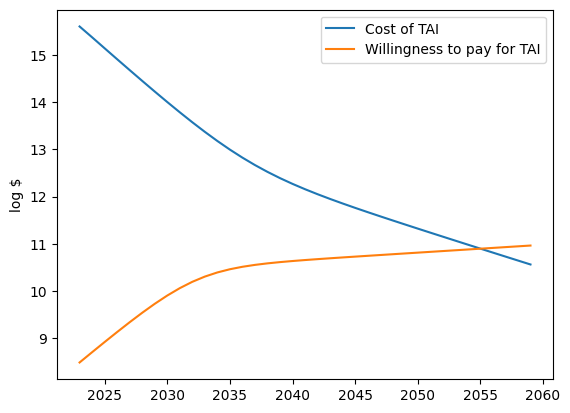

-
-
## SAMPLE RUN 47 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~243 million). This doubles every 3.7 years to a max of 0.032384% of GDP. GDP grows at a rate of 1.038x per year.
---
Year: 2023 - 26.7 max log FLOP (470 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 8.4 (235 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (777 septillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.4 to buy TAI (2 billion) vs. willingness to pay log $ 8.5 (282 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.8)
Y

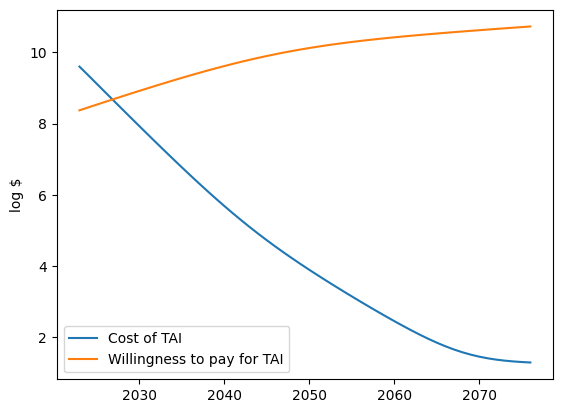

-
-
## SAMPLE RUN 48 ##
It takes 38.3 log FLOP (~200 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~404 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 1.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 38.3 log FLOP (200 thousand decillion) - log $ 20.0 to buy TAI (100 quintillion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 38.0 log FLOP (100 thousand decillion) - log $ 19.5 to buy TAI (35 quintillion) vs. willingness to pay log $ 8.7 (455 million) - 18.5 log FLOP per $ (3 qui

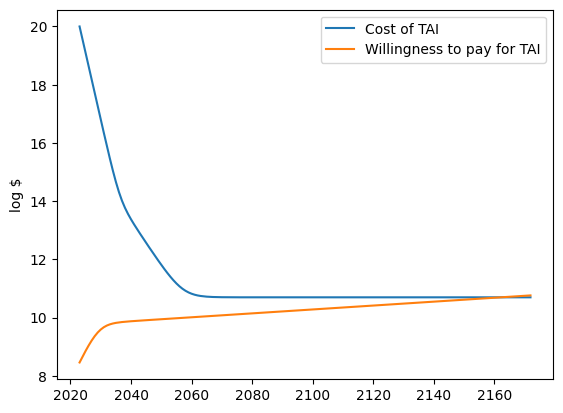

-
-
## SAMPLE RUN 49 ##
It takes 31.1 log FLOP (~13 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~27 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~250 million). This doubles every 3.0 years to a max of 0.192933% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.7 max log FLOP (496 septillion) available - TAI takes 31.1 log FLOP (13 nonillion) - log $ 12.8 to buy TAI (6 trillion) vs. willingness to pay log $ 8.4 (248 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (884 septillion) available - TAI takes 31.0 log FLOP (10 nonillion) - log $ 12.5 to buy TAI (3 trillion) vs. willingness to pay log $ 8.5 (312 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLO

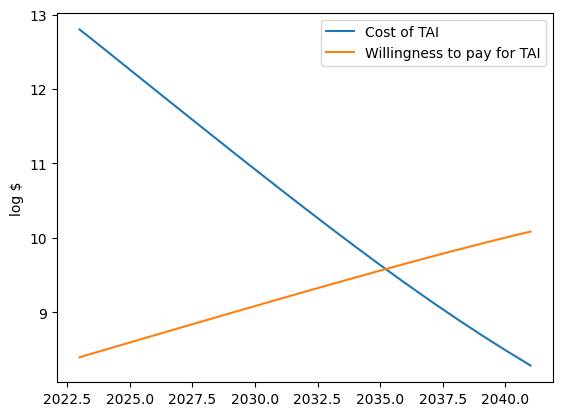

-
-
## SAMPLE RUN 50 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~14 septillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 2.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 26.8 log FLOP (631 septillion) - log $ 8.5 to buy TAI (316 million) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.5 max log FLOP (341 septillion) available - TAI takes 26.7 log FLOP (507 septillion) - log $ 8.3 to buy TAI (199 million) vs. willingness to pay log $ 8.1 (134 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP

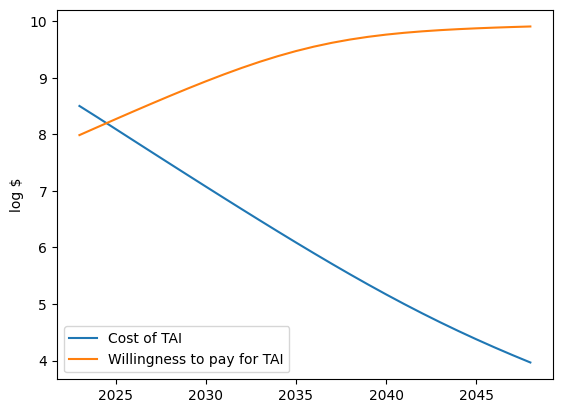

-
-
## SAMPLE RUN 51 ##
It takes 28.8 log FLOP (~63 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 2.8 years to a max of 0.025069% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 28.8 log FLOP (63 octillion) - log $ 10.5 to buy TAI (32 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.7 log FLOP (51 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 8.6 (442 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

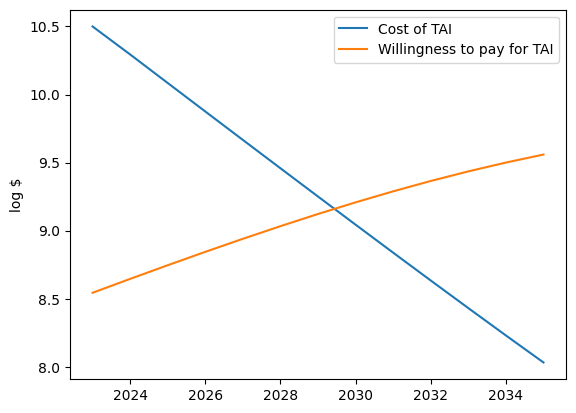

-
-
## SAMPLE RUN 52 ##
It takes 31.1 log FLOP (~13 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~54 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~199 million). This doubles every 2.9 years to a max of 0.422546% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.6 max log FLOP (396 septillion) available - TAI takes 31.1 log FLOP (13 nonillion) - log $ 12.8 to buy TAI (6 trillion) vs. willingness to pay log $ 8.3 (199 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.9 max log FLOP (754 septillion) available - TAI takes 31.0 log FLOP (10 nonillion) - log $ 12.5 to buy TAI (3 trillion) vs. willingness to pay log $ 8.4 (252 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLO

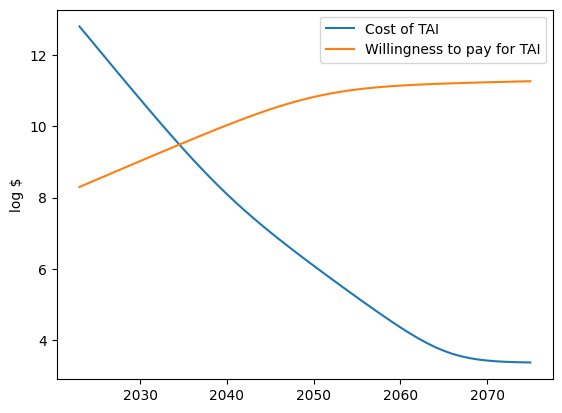

-
-
## SAMPLE RUN 53 ##
It takes 25.3 log FLOP (~20 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 26.3 log FLOP (~213 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~769 million). This doubles every 1.8 years to a max of 0.104147% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 25.3 log FLOP (20 septillion) - log $ 7.0 to buy TAI (10 million) vs. willingness to pay log $ 8.9 (745 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 33 years (total delay 41 years)
-- data p_nons

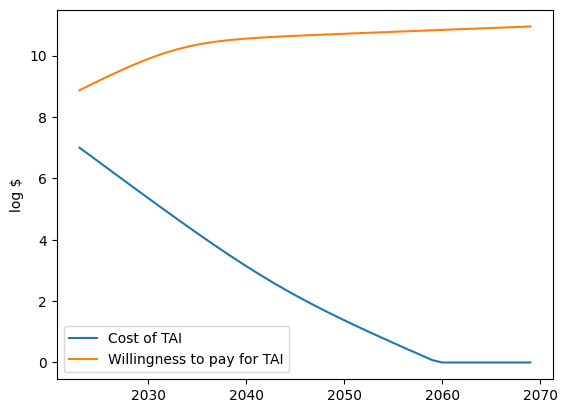

In [10]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)